## Library Importation

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Graph Configuration

In [3]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

## Data Import

In [5]:
# Establish connection to database
conn = pyodbc.connect('Driver={SQL Server};' 
                      'Server=DESKTOP-PKKQIAI;' 
                      'Database=AdventureWorksDW2019;' 
                      'Trusted_Connection=yes;')

In [7]:
sql_for_df = "SELECT [CustomerKey], DATEDIFF(DAY, MAX([OrderDate]), '2014-01-28 00:00:00.000') AS Recency, \
                COUNT(DISTINCT [SalesOrderNumber]) AS Frequency, \
                SUM([SalesAmount]) AS Monetary \
                FROM [dbo].[FactInternetSales] \
                GROUP BY [CustomerKey]"

rfm_df = pd.read_sql(sql_for_df, conn)

# Close connection
conn.close()

## Preliminary EDA

In [8]:
# Check first few rows
rfm_df.head()

,CustomerKey,Recency,Frequency,Monetary
0,28387,71,1,583.9700
1,14324,134,3,5121.4282
2,19897,70,1,596.9600
3,22814,310,1,4.9900
4,11407,219,1,53.9900


In [9]:
# Check dimensions
rfm_df.shape

(18484, 4)

In [10]:
# Check column information
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerKey  18484 non-null  int64  
 1   Recency      18484 non-null  int64  
 2   Frequency    18484 non-null  int64  
 3   Monetary     18484 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 577.8 KB


In [11]:
# Check high level stats of columns
rfm_df.describe()

,CustomerKey,Recency,Frequency,Monetary
count,18484.000000,18484.000000,18484.000000,18484.000000
mean,20241.500000,189.332450,1.496375,1588.329216
std,5336.015523,146.288729,1.101139,2124.231717
min,11000.000000,0.000000,1.000000,2.290000
25%,15620.750000,86.000000,1.000000,49.970000
50%,20241.500000,168.000000,1.000000,270.265000
75%,24862.250000,263.000000,2.000000,2511.275000
max,29483.000000,1126.000000,28.000000,13295.380000


In [12]:
# Ensure each customer is assigned to an individual row
rfm_df['CustomerKey'].nunique()

18484

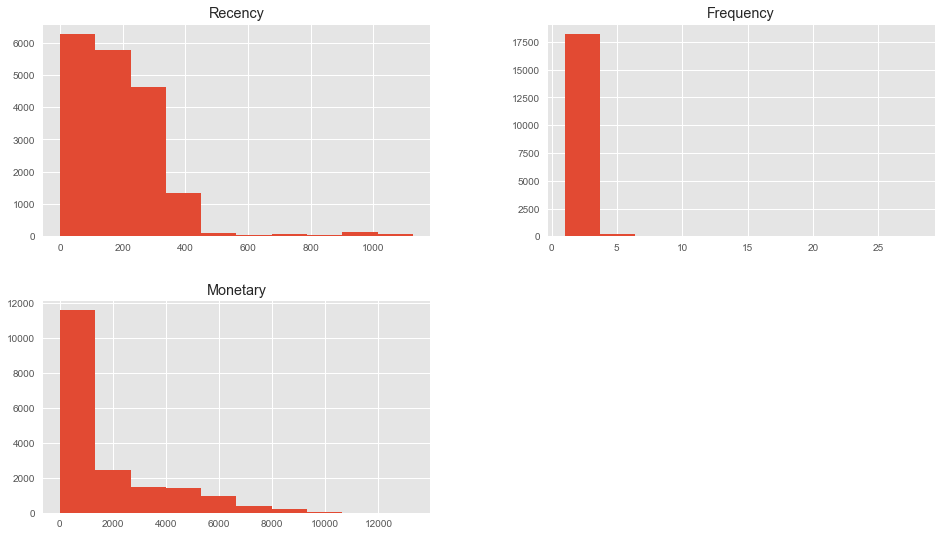

In [13]:
# Check feature distributions
rfm_df.drop(['CustomerKey'], axis = 1).hist();

## Assign Recency, Frequency, and Monetary Scores

### Recency - R score

In [15]:
# Assign scores by putting values into 5 equal-sized buckets based on the sample quantiles. 
#The list should be in reverse order because more recent purchases (i.e. lower values) score higher
rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 5, labels = [5, 4, 3, 2, 1]) 

### Monetary - M score

In [16]:
# Assign scores by putting values into 5 equal-sized buckets based on the sample quantiles. 
# Higher spend/monetary values score higher
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], 5, labels = [1, 2, 3, 4, 5])

### Frequency - F score

In [17]:
rfm_df['Frequency'].nunique()

12

In [18]:
rfm_df['Frequency'].unique()

array([ 1,  3,  2,  4, 16,  5, 27, 17,  7,  6, 28, 25], dtype=int64)

In [19]:
# Because the values of the Frequency column are so few, the bins need to be created manually
rfm_df['F_score'] = pd.cut(rfm_df['Frequency'], 
                        bins = [1, 5, 10, 15, 20, 30],
                        labels = [1, 2, 3, 4, 5],
                        right = False)

In [20]:
rfm_df.head()

,CustomerKey,Recency,Frequency,Monetary,R_score,M_score,F_score
0,28387,71,1,583.9700,5,3,1
1,14324,134,3,5121.4282,3,5,1
2,19897,70,1,596.9600,5,3,1
3,22814,310,1,4.9900,1,1,1
4,11407,219,1,53.9900,2,2,1


In [21]:
rfm_df.tail()

,CustomerKey,Recency,Frequency,Monetary,R_score,M_score,F_score
18479,18394,43,1,2297.28,5,4,1
18480,25968,71,1,24.99,5,1,1
18481,12984,91,4,200.20,4,3,1
18482,17312,77,2,4471.74,4,5,1
18483,15148,235,2,90.75,2,2,1


### Overall RFM Score

In [22]:
# Calculate RFM scores (i.e. an average of the three individual scores)
rfm_df['RFM_score'] = (rfm_df['R_score'].astype(int) + rfm_df['F_score'].astype(int) + rfm_df['M_score'].astype(int)) / 3
rfm_df['RFM_score'] = rfm_df['RFM_score'].round(2)

rfm_df.head()

,CustomerKey,Recency,Frequency,Monetary,R_score,M_score,F_score,RFM_score
0,28387,71,1,583.9700,5,3,1,3.00
1,14324,134,3,5121.4282,3,5,1,3.00
2,19897,70,1,596.9600,5,3,1,3.00
3,22814,310,1,4.9900,1,1,1,1.00
4,11407,219,1,53.9900,2,2,1,1.67


In [23]:
# Assign values to customers based on RFM scores where rfm score > 4 : High Value Customer, 
# 4>rfm score >3 : Medium value customer, 3>rfm score>1.6 : Low-value customer
# rfm score<1.6 :Lost Customer
# Create list of conditions
conditions = [
    (rfm_df['RFM_score'] < 1.5),
    (rfm_df['RFM_score'] >= 1.5) & (rfm_df['RFM_score'] < 2.5),
    (rfm_df['RFM_score'] >= 2.5) & (rfm_df['RFM_score'] < 4),
    (rfm_df['RFM_score'] >= 4) 
]

# Create list of values to be assigned to each condition
labels = ['Lost Customer', 'Low-value Customer', 'Medium-value Customer', 'High-value Customer']

In [24]:
# Create new column which assigns the labels to the RFM scores
rfm_df['CustomerLevels'] = np.select(conditions, labels)

In [25]:
rfm_df.head()

,CustomerKey,Recency,Frequency,Monetary,R_score,M_score,F_score,RFM_score,CustomerLevels
0,28387,71,1,583.9700,5,3,1,3.00,Medium-value Customer
1,14324,134,3,5121.4282,3,5,1,3.00,Medium-value Customer
2,19897,70,1,596.9600,5,3,1,3.00,Medium-value Customer
3,22814,310,1,4.9900,1,1,1,1.00,Lost Customer
4,11407,219,1,53.9900,2,2,1,1.67,Low-value Customer


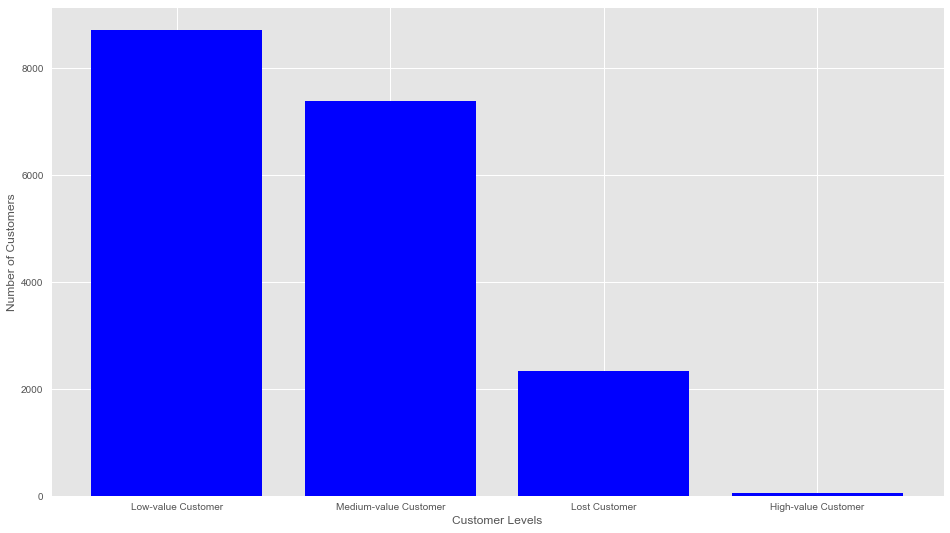

In [26]:
# Visualise customer levels
plt.bar(rfm_df['CustomerLevels'].value_counts().index, rfm_df['CustomerLevels'].value_counts(), color ='blue')
plt.xlabel('Customer Levels')
plt.ylabel('Number of Customers')

plt.show();